 - Compare your CNN based models with a DINOv2-based model used as a fixed feature extractor. Is DINOv2 better?
 - Investigate your model. In what types of images does it fail? Why do you think so?
 - Evaluate your model on a few images from completely different robots from those seen during training? How does it perform?

# Part 1

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import shutil
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

print(torch.cuda.is_available())

2025-05-05 23:01:08.188810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 23:01:08.204033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746478868.220848   30660 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746478868.226422   30660 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746478868.239349   30660 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

True


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../dataset/'
save_model_dir='../models/'
tensorboard_dir='../tboard_logs/'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"),data_transforms["validation"])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"),data_transforms["test"])
unseen_dataset = datasets.ImageFolder(os.path.join(data_dir, "unseen_robots"),data_transforms["test"])

N_train = len(train_dataset)
N_valid = len(valid_dataset)
N_test = len(test_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")
print(f"Test set size: {N_test} images")
print(f"Unseen Robot set size: {len(unseen_dataset)} images")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
unseen_loader= torch.utils.data.DataLoader(unseen_dataset, batch_size=32, shuffle=False, num_workers=4)

Training set size: 300 images
Valdiation set size: 60 images
Test set size: 42 images
Unseen Robot set size: 42 images


In [3]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list

@torch.no_grad()
def eval_model(model, eval_loader, criterion, device,get_false_predictions=False):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass only to get logits/output
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        #print(f"{preds=}") should be deleted
        wrong_mask = preds != labels
        #print(f"Wrong predictions: {torch.sum(wrong_mask)}") should be deleted
        #print(f"Wrong mask: {wrong_mask=}") should be deleted
        if get_false_predictions and wrong_mask.any():
            wrong_images.append(images[wrong_mask])
            wrong_preds.append(preds[wrong_mask])
            wrong_labels.append(labels[wrong_mask])

        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)

    if(not get_false_predictions):
        return accuracy, loss
    return accuracy, loss, wrong_images, wrong_preds

def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    assert tboard is not None, f"Tensorboard must be provided!"
    
    for epoch in tqdm(range(num_epochs)):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        tboard.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        tboard.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def save_model(directory,model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists(f"{directory}")):
        os.makedirs(f"{directory}")
    savepath = f"{directory}checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath,weights_only=False):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath,weights_only=weights_only)
    #model.load_state_dict(checkpoint['model_state_dict']) ????
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict']) ????
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

def show_grid(data, titles=None, sup_title=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean  # IMPORTANT! If you normalize imgs in the DataLoader, undo the norm. for visualization
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        if i >= len(data):
            break
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if sup_title is not None:
            plt.suptitle(sup_title)
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

In [4]:
import timm
from timm.models.vision_transformer import _create_vision_transformer, VisionTransformer
from functools import partial

model_kwargs = dict(
        patch_size=14,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        num_classes=0,
        img_size=224,  # default was 518
    )

dinov2 = timm.create_model(
            "vit_small_patch14_dinov2.lvd142m",
            pretrained=True,
            **model_kwargs
        )
device = torch.device("cuda")

In [5]:
set_random_seed()

# Freezing model parameters
for param in dinov2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_logits = dinov2.norm.normalized_shape[0]

dinov2.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)
# dinov2.head = nn.Linear(num_logits, 2)

dinov2 = dinov2.to(device)

In [6]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(dinov2.parameters(), lr=1e-4)

# Decay LR by a factor of 0.3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [7]:
TBOARD_LOGS = os.path.join(os.getcwd(), f"{tensorboard_dir}", "Transformer", "DINOv2")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [8]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=dinov2, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

  7%|▋         | 1/15 [00:07<01:48,  7.77s/it]

Epoch 1/15
    Train loss: 0.48654
    Valid loss: 0.70884
    Accuracy: 55.00000000000001%




 40%|████      | 6/15 [00:47<01:10,  7.84s/it]

Epoch 6/15
    Train loss: 0.0849
    Valid loss: 0.04827
    Accuracy: 100.0%




 73%|███████▎  | 11/15 [01:34<00:34,  8.73s/it]

Epoch 11/15
    Train loss: 0.05767
    Valid loss: 0.03817
    Accuracy: 100.0%




100%|██████████| 15/15 [02:07<00:00,  8.52s/it]

Epoch 15/15
    Train loss: 0.09114
    Valid loss: 0.037
    Accuracy: 100.0%


Training completed


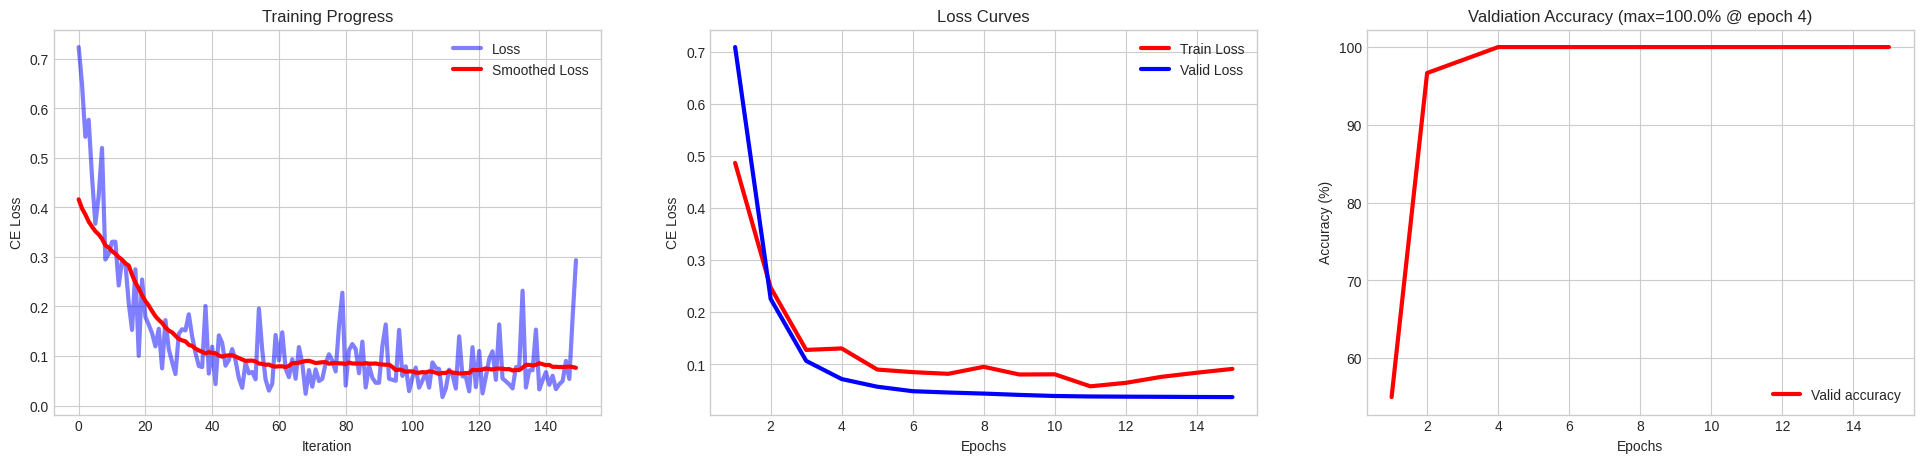

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

In [10]:
dinov2.eval()

accuracy, loss= eval_model(
                    model=dinov2, eval_loader=test_loader,
                    criterion=criterion, device=device
            )

print(f"{accuracy=}, {loss=}")

accuracy=97.61904761904762, loss=np.float64(0.08725715987384319)


In [11]:
save_model(save_model_dir,dinov2, optimizer, len(epochs), stats={"train_loss": train_loss, "val_loss": val_loss, "valid_acc": valid_acc, "test_loss": loss, "test_acc": accuracy})

# Part 2

In [12]:
dinov2 = timm.create_model(
            "vit_small_patch14_dinov2.lvd142m",
            pretrained=True,
            **model_kwargs
        )
device = torch.device("cuda")
model=dinov2.to(device)
optimizer = torch.optim.Adam(dinov2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

model, optimizer, epoch, stats= load_model(model, optimizer, "../models/checkpoint_epoch_15.pth",weights_only=False)

False predicted images:


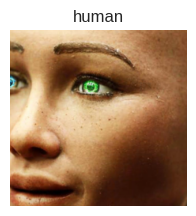

In [12]:
dinov2.to(device)
dinov2.eval()
accuracy, loss,false_predicted_images,false_predicted_labels  = eval_model(
                    model=dinov2, eval_loader=test_loader,
                    criterion=criterion, device=device,get_false_predictions=True
            )
allImages = torch.tensor([]).to(device)
classes = torch.tensor([]).to(device)
class_names = train_dataset.classes
for i in range(len(false_predicted_images)):
    allImages=torch.cat([allImages,false_predicted_images[i]], dim=0)

for i in range(len(false_predicted_labels)):
    classes=torch.cat([classes,false_predicted_labels[i]], dim=0)
titles = [class_names[int(x.item())] for x in classes]
print("False predicted images:")
show_grid(allImages.to("cpu"), titles=titles)

#### The model makes mistakes to detect the robots that are deeply looking like humans. In this case, the robot is detectable regarding its eyes. So we have to add more images of robots which are human like but their eyes are different than human to make more sophisticated prediction model.


# Part 3

In [ ]:
dinov2 = timm.create_model(
            "vit_small_patch14_dinov2.lvd142m",
            pretrained=True,
            **model_kwargs
        )
device = torch.device("cuda")
model=dinov2.to(device)
optimizer = torch.optim.Adam(dinov2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

model, optimizer, epoch, stats= load_model(model, optimizer, "../models/checkpoint_epoch_15.pth",weights_only=False)

False predicted images:


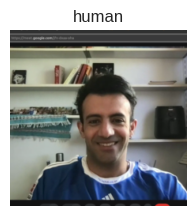

In [13]:
dinov2.to(device)
dinov2.eval()
unseen_accuracy, unseen_loss,unseen_false_predicted_images,unseen_false_predicted_labels  = eval_model(
                    model=dinov2, eval_loader=unseen_loader,
                    criterion=criterion, device=device,get_false_predictions=True
            )
allImages = torch.tensor([]).to(device)
classes = torch.tensor([]).to(device)
class_names = train_dataset.classes
for i in range(len(unseen_false_predicted_images)):
    allImages=torch.cat([allImages,unseen_false_predicted_images[i]], dim=0)

for i in range(len(unseen_false_predicted_labels)):
    classes=torch.cat([classes,unseen_false_predicted_labels[i]], dim=0)
titles = [class_names[int(x.item())] for x in classes]
print("False predicted images:")
try:
    show_grid(allImages.to("cpu"), titles=titles)
except:
    print("All the predictions were correct :) ") # We only predict false predicted images.

This image was categorized inside the robot folder on purpose, so it is literaly a robot, but our model detects it as a human. That means our model has trained human features very well.

Also the model detects all the unseen robots with 100% accuracy.